Projeto de Inteligência Artifical voltado para o Reconhecimento da Datilologia

Grupo: Alina Tainá Germano Costa, Júlia de Oliveira Tavares, Lucas Emanuel Camilo Bezerra e Pedro Henrique Correia Bezerra Silva

A FAZER:
- CRIAR GRÁFICOS: MUITO IMPORTANTE PARA ENTENDER OS RESULTADOS DOS MODELOS
- DIVIDIR A PARTE DE VALIDAÇÃO
- USAR A BIBLIOTECA GRIDSEARCHCV
- RESPONDER O RELATÓRIO COM BASE NOS RESULTADOS OBTIDOS 
- APRESENTAR COM FUNDAMENTO SOBRE O PORQUÊ DAS NOSSAS ESCOLHAS

POSSIBILIDADE: 
- ALGORITMOS DE OTIMIZAÇÃO JUNTO DO GRIDSEARCHCV
- IDENTIFICAR O SINAL PELA WEBCAM AO VIVO

In [ ]:
# import de algumas bibliotecas essenciais: PIL, Image - faz o processo de conversão da imagem; Numpy - fundamental para a manipulação de dados; 
# Matplotlib.pyplot - essencial para a plotagem de gráficos; os - necessária para acessar as imagens dentro do diretório "datilologia"
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os

In [ ]:
# Carregar os dados preparados
x_treino = np.load('x_treino.npy')  # Carrega as imagens de treinamento
y_treino = np.load('y_treino.npy')  # Carrega os rótulos de treinamento

x_validacao = np.load('x_validacao.npy')  # Carrega as imagens de validação
y_validacao = np.load('y_validacao.npy')  # Carrega os rótulos de validação

x_teste = np.load('x_teste.npy')  # Carrega as imagens de teste
y_teste = np.load('y_teste.npy')  # Carrega os rótulos de teste

In [ ]:
# Entender o formato 'shape' do array
data_shape = np.shape(x_treino)
print(data_shape)


# Realizar a reformatação do array para que consiga entrar no modelo KNN ('reshape')
x_treino = np.reshape(x_treino, (data_shape[0], data_shape[1] * data_shape[2]))
print(np.shape(x_treino))

x_validacao = np.reshape(x_validacao, (data_shape[0], data_shape[1] * data_shape[2]))
print(np.shape(x_validacao))

x_teste = np.reshape(x_teste, (data_shape[0], data_shape[1] * data_shape[2]))
print(np.shape(x_teste))

(34714, 64, 64)
(34714, 4096)


In [ ]:
# GRIDSEARCHCV
knn_grid = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 9],  
    'metric': ['euclidean']  
}

grid_search = GridSearchCV(estimator=knn_grid, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1)

grid_search.fit(x_treino, y_treino)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'], 'n_neighbors': [3, 5, 9]},
             scoring='accuracy', verbose=1)

In [32]:
# GRIDSEARCHCV

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best score during cross-validation
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
Best CV Accuracy: 0.9857765748368927


In [ ]:
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], metric=grid_search.best_params_['metric'])

knn.fit(x_treino, y_treino)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [ ]:
train_accuracy = accuracy_score(y_validacao, knn.predict(x_validacao))
print(train_accuracy)

0.9956791012530606


In [38]:
# GRIDSEARCHCV

# Test set performance
#best_knn = grid_search.best_estimator_
#test_accuracy = best_knn.score(x_test, y_test)
#print("Test Accuracy:", test_accuracy)

In [ ]:
# Realizar a predição
y_pred = knn.predict(x_teste)
print(y_pred)

[ 1  1  1 ... 25 25 25]


In [ ]:
# Informar a acurácia do modelo
test_accuracy = accuracy_score(y_teste, y_pred)  
print("Acurácia:", test_accuracy)

Acurácia: 0.9127987530308278


In [ ]:
# Entender onde o modelo se confunde
conf_matrix = confusion_matrix(y_teste, y_pred)
print("Matriz de confusão:\n", conf_matrix)

Matriz de confusão:
 [[526   0   0  12  21   0   0   0   0   0   0   6   0   0   0  14   0   0
    0   0   0]
 [  0 551   0   0   1   0   0   0   0   0   0   0   0   0   7   0   0   3
    0   0   0]
 [  0   7 542  15   0   0   0   0  19   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  1   0   0 532   8   0   5   4   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 11  16   0  36 466   0   2  29   0   0   0   0   0   0   6   8   0   0
    0   0   0]
 [  0   8   0   0   0 414   0   6   0   0   0  17   0   0   0   0   4   0
    0   0   1]
 [  3   0   0  26   0   0 481   0  17   0   0   0   0   0   7  16   0   0
    0   0   0]
 [  8   0   0   0   6   0   2 533   0   0   0   0   0   0   0   1   0   0
    0   0   0]
 [ 16   0   0   9   0   0   1   0 515   0   0   0   0   0   8   1   0   0
    0   0   0]
 [  0   0   0   0   0   0   0   0   0 531   6   0   0  13   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0   0   0   0  69 464   0   0  17   0   0   0   0
    0   0   0]


In [ ]:
# Exibe na tela o relatório de classificação
report = classification_report(y_teste, y_pred)
print("Relatório de classificação:\n", report)

Relatório de classificação:
               precision    recall  f1-score   support

           1       0.88      0.91      0.89       579
           2       0.86      0.98      0.91       562
           3       0.97      0.93      0.95       583
           4       0.78      0.97      0.86       550
           5       0.89      0.81      0.85       574
           6       0.88      0.92      0.90       450
           7       0.97      0.87      0.92       550
           9       0.86      0.97      0.91       550
          12       0.93      0.94      0.94       550
          13       0.87      0.97      0.92       550
          14       0.96      0.84      0.90       550
          15       0.96      0.92      0.94       550
          16       1.00      1.00      1.00       550
          17       0.95      0.97      0.96       550
          18       0.85      0.77      0.81       550
          19       0.89      0.83      0.86       550
          20       0.91      0.86      0.88       55

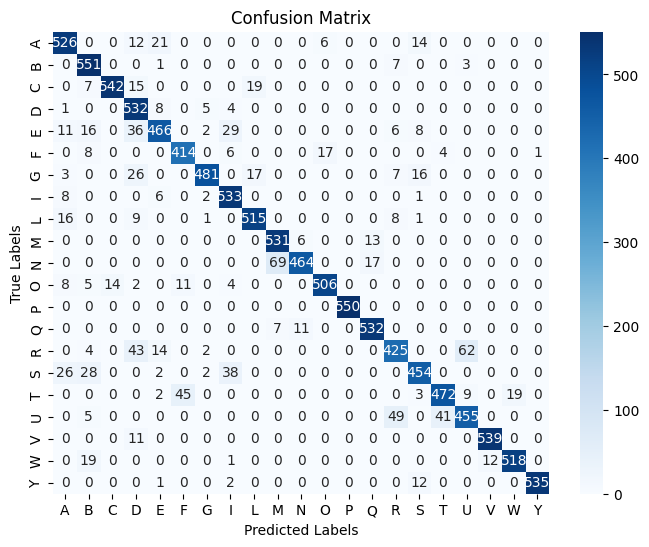

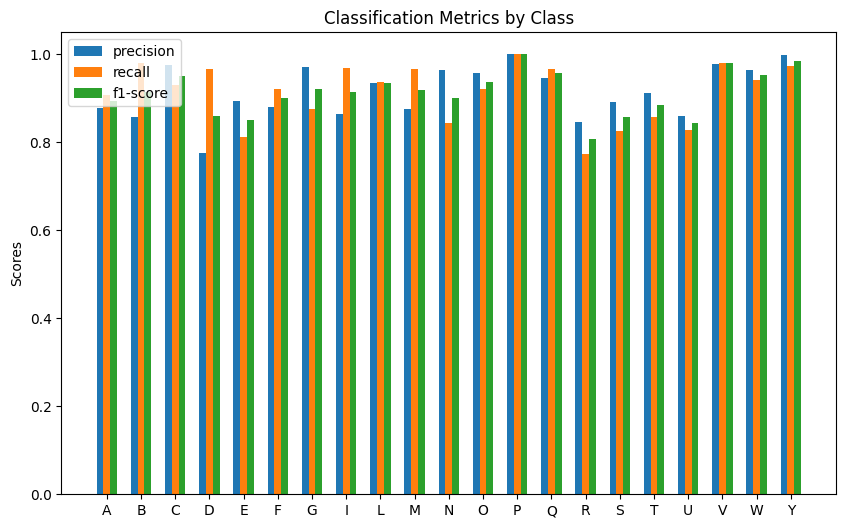

In [ ]:
# Código para gerar gráficos de métricas do modelo.
letras = ["A", "B", "C", "D", "E", "F", "G", "I", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "Y"]
y_prob = knn.predict_proba(x_teste)

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Função para plotar métricas de classificação
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    data = {metric: [report[cls][metric] for cls in class_names] for metric in metrics}
    x = np.arange(len(class_names))

    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * 0.2, data[metric], width=0.2, label=metric)

    plt.xticks(x + 0.2, class_names)
    plt.ylabel('Scores')
    plt.title('Classification Metrics by Class')
    plt.legend()
    plt.show()

# Função para plotar Curvas ROC e AUC (One-vs-All para multi-classe)
def plot_roc_curves(y_true, y_scores, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

# Código de exemplo (ajustar conforme as variáveis do notebook)
plot_confusion_matrix(y_teste, y_pred, letras)
plot_classification_report(y_teste, y_pred, letras)
#plot_roc_curves(y_test, y_prob, letras)


In [ ]:
print(y_teste)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Definir o PCA para reter 95% da variância dos dados
pca = PCA(n_components=0.95)  # Retém 95% da variância
x_treino_pca = pca.fit_transform(x_treino)
x_teste_pca = pca.transform(x_teste)

print("TREINAMENTO")
print(f"Dimensões originais: {np.shape(x_treino)}")
print(f"Dimensões após PCA: {np.shape(x_treino_pca)}")
print("TESTE")
print(f"Dimensões originais: {np.shape(x_teste)}")
print(f"Dimensões após PCA: {np.shape(x_teste_pca)}")

TREINAMENTO
Dimensões originais: (34714, 4096)
Dimensões após PCA: (34714, 229)
TESTE
Dimensões originais: (11548, 4096)
Dimensões após PCA: (11548, 229)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Melhores Parâmetros: {'metric': 'euclidean', 'n_neighbors': 3}
Melhor Acurácia na Validação Cruzada: 0.9857765748368927
Acurácia no Treinamento: 0.9956791012530606
Acurácia no Teste: 0.9127987530308278


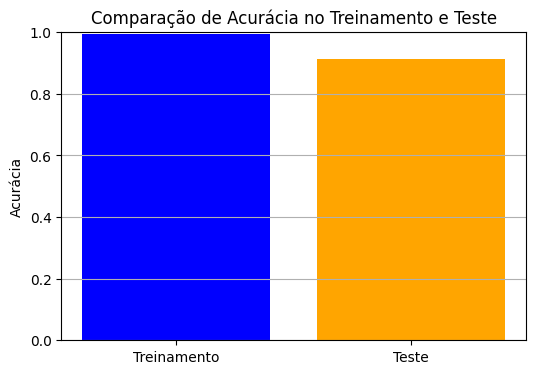

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

           1       0.88      0.91      0.89       579
           2       0.86      0.98      0.91       562
           3       0.97      0.93      0.95       583
           4       0.78      0.97      0.86       550
           5       0.89      0.81      0.85       574
           6       0.88      0.92      0.90       450
           7       0.97      0.87      0.92       550
           9       0.86      0.97      0.91       550
          12       0.93      0.94      0.94       550
          13       0.87      0.97      0.92       550
          14       0.96      0.84      0.90       550
          15       0.96      0.92      0.94       550
          16       1.00      1.00      1.00       550
          17       0.95      0.97      0.96       550
          18       0.85      0.77      0.81       550
          19       0.89      0.83      0.86       550
          20       0.91      0.86      0.88 

In [ ]:
# GRIDSEARCHCV com PCA

# Modelo e hiperparâmetros
knn_grid = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 15],
    'metric': ['euclidean']
}

# Busca de hiperparâmetros com validação cruzada
grid_search = GridSearchCV(estimator=knn_grid, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1)
grid_search.fit(x_treino, y_treino)

# Melhores parâmetros
print("Melhores Parâmetros:", grid_search.best_params_)
print("Melhor Acurácia na Validação Cruzada:", grid_search.best_score_)

# Modelo com os melhores hiperparâmetros
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], metric=grid_search.best_params_['metric'])
knn.fit(x_treino, y_treino)

# Acurácia no conjunto de treinamento
y_train_pred = knn.predict(x_validacao)
train_accuracy = accuracy_score(y_validacao, y_train_pred)
print("Acurácia no Treinamento:", train_accuracy)

# Acurácia no conjunto de teste
y_test_pred = knn.predict(x_teste)
test_accuracy = accuracy_score(y_teste, y_test_pred)
print("Acurácia no Teste:", test_accuracy)

# Visualização dos resultados
plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia no Treinamento e Teste')
plt.grid(axis='y')
plt.show()

# Detalhes adicionais
print("Relatório de Classificação no Teste:")
print(classification_report(y_teste, y_test_pred))

print("Matriz de Confusão no Teste:")
print(confusion_matrix(y_teste, y_test_pred))


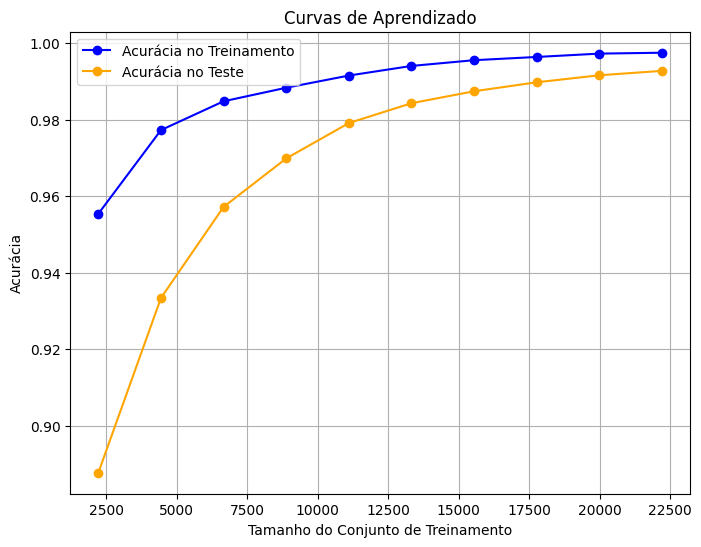

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, x_treino, y_treino, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Acurácia no Treinamento', marker='o', color='blue')
plt.plot(train_sizes, test_mean, label='Acurácia no Teste', marker='o', color='orange')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.title('Curvas de Aprendizado')
plt.legend()
plt.grid()
plt.show()


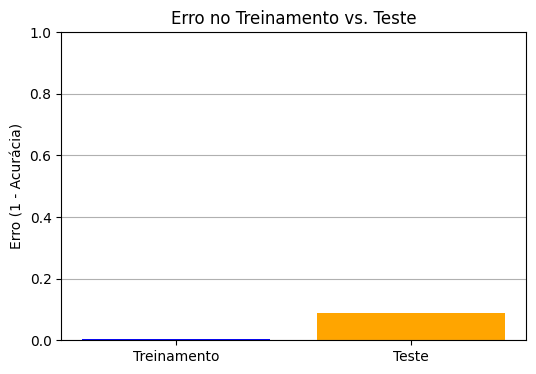

In [48]:
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

plt.figure(figsize=(6, 4))
plt.bar(['Treinamento', 'Teste'], [train_error, test_error], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Erro (1 - Acurácia)')
plt.title('Erro no Treinamento vs. Teste')
plt.grid(axis='y')
plt.show()
